# OSIC Keras Starter: Neural Network (optimized with custom hyperparameters)

> **Check out my EDA with animations and much more:** https://www.kaggle.com/aadhavvignesh/animations-dicom-eda-osic-starter-notebook

![Adam](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F770%2F1*5Q1ZlbpP-C4wzJVtVfGn5Q.png&f=1&nofb=1)

This kernel is inspired by @ulrich07 's starter notebook, please do upvote his kernel too :)

https://www.kaggle.com/ulrich07/osic-multiple-quantile-regression-starter

In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

from tqdm import tqdm
from PIL import Image
import pydicom

Let's set a seed:

In [2]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [3]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE = 128

# Data Preprocessing:

In [4]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

sub = pd.read_csv(f"{ROOT}/sample_submission.csv")

sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))

sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

In [5]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'

data = tr.append([chunk, sub])

In [6]:
data['min_week'] = data['Weeks']

data.loc[data.WHERE=='test','min_week'] = np.nan

data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [7]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']

base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')

base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [8]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [9]:
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [10]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [11]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

# Building the Model:

Let's proceed to build a basic NN:

In [12]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)


def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

Here's where the real magic happens, the hyperparameters:

In [13]:
LR = 0.1
BETA_1 = 0.9
BETA_2 = 0.999
DECAY = 0.01
AMSGRAD = False

Let's create the optimizer with our hand-picked hyperparameters:

In [14]:
# Adam_Optimized = tf.keras.optimizers.Adam(lr = LR, beta_1 = BETA_1, beta_2 = BETA_2, epsilon = None, decay = DECAY, amsgrad = AMSGRAD)

Let's proceed to create the model:

In [15]:
def make_model():
    z = L.Input((9,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="NN-Optimized")
    model.compile(loss=mloss(0.8), optimizer = tf.keras.optimizers.Adam(lr = LR, beta_1 = BETA_1, beta_2 = BETA_2, epsilon = None, decay = DECAY, amsgrad = AMSGRAD), metrics=[score])
    return model

In [16]:
net = make_model()
print(net.summary())
print(net.count_params())

Model: "NN-Optimized"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
_______________________________________________________________________________________

In [17]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

This kernel uses 10-fold, you change the number of folds:

In [18]:
NFOLD = 10
kf = KFold(n_splits=NFOLD)

Let's fit the model and generate predictions:

In [19]:
%%time
count = 0
for train_idx, val_idx in kf.split(z):
    count += 1
    print(f"FOLD {count}:")
    
    # Create and fit model
    net = make_model()
    net.fit(z[train_idx], y[train_idx], batch_size=BATCH_SIZE, epochs=850, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    
    # Evaluate
    print("Train:", net.evaluate(z[train_idx], y[train_idx], verbose=0, batch_size=BATCH_SIZE))
    print("Val:", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    
    # Generate predictions
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("Predicting Test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1:
Train: [38.565277099609375, 6.454725742340088]
Val: [48.29994583129883, 6.620980739593506]
Predicting Test...
FOLD 2:
Train: [39.78889465332031, 6.500656604766846]
Val: [43.117401123046875, 6.638520240783691]
Predicting Test...
FOLD 3:
Train: [39.36542892456055, 6.471258163452148]
Val: [47.951297760009766, 6.6792497634887695]
Predicting Test...
FOLD 4:
Train: [39.32200622558594, 6.476892471313477]
Val: [41.85483932495117, 6.517056941986084]
Predicting Test...
FOLD 5:
Train: [39.460872650146484, 6.470716953277588]
Val: [61.257843017578125, 6.9202680587768555]
Predicting Test...
FOLD 6:
Train: [40.13526153564453, 6.496589183807373]
Val: [50.05178451538086, 6.539479732513428]
Predicting Test...
FOLD 7:
Train: [42.25862503051758, 6.562736988067627]
Val: [36.94819259643555, 6.539848804473877]
Predicting Test...
FOLD 8:
Train: [40.49772644042969, 6.511470317840576]
Val: [40.200721740722656, 6.455022811889648]
Predicting Test...
FOLD 9:
Train: [41.681339263916016, 6.546078205108643]
V

In [20]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

137.6008241137775 233.71953474908386


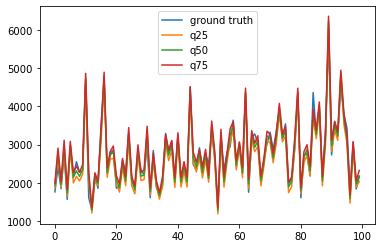

In [21]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [22]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

60.081298828125 233.71953474908386 416.051513671875 1.0


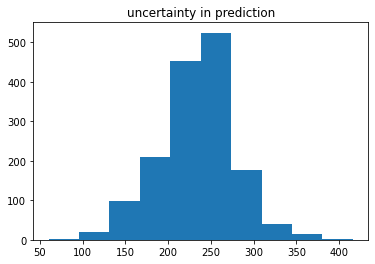

In [23]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

# Creating the Submission file

We've got our predictions, but there's a whole lot of work to do for bringing it to the valid submission format.

Let's start cleaning!

In [24]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [25]:
sub['FVC1'] = pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [26]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [27]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2856.498444,238.763977
1541,ID00419637202311204720264_-11,3020,100.0,2854.018555,239.802582
1542,ID00419637202311204720264_-10,3020,100.0,2851.540955,240.904114
1543,ID00419637202311204720264_-9,3020,100.0,2849.063416,242.005676
1544,ID00419637202311204720264_-8,3020,100.0,2846.585938,243.107239
1545,ID00419637202311204720264_-7,3020,100.0,2844.108368,244.208832
1546,ID00419637202311204720264_-6,3020,100.0,2841.630890,245.310364
1547,ID00419637202311204720264_-5,3020,100.0,2839.153290,246.412018
1548,ID00419637202311204720264_-4,3020,100.0,2836.700897,247.520660
1549,ID00419637202311204720264_-3,3020,100.0,2834.290497,248.640900


In [28]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']

if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [29]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2856.498444,238.763977,2856.498444,238.763977
1541,ID00419637202311204720264_-11,2854.018555,239.802582,2854.018555,239.802582
1542,ID00419637202311204720264_-10,2851.540955,240.904114,2851.540955,240.904114
1543,ID00419637202311204720264_-9,2849.063416,242.005676,2849.063416,242.005676
1544,ID00419637202311204720264_-8,2846.585938,243.107239,2846.585938,243.107239


In [30]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2637.292930,329.619359,1933.703506,2575.331066,2685.770172,2816.722580,3202.993256
Confidence,730.0,285.090709,46.329604,184.812424,248.961567,285.010521,324.373901,371.748962
FVC1,730.0,2637.292930,329.619359,1933.703506,2575.331066,2685.770172,2816.722580,3202.993256
Confidence1,730.0,285.090709,46.329604,184.812424,248.961567,285.010521,324.373901,371.748962


In [31]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

Finally, let's append this to the submission file:

In [32]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

## Feel free to suggest ideas!

Do check out other kernels too! (Link in the comments)